# Evaluation notebook

Important general notes: there are three parts to evaluation framework a) the assumptions testing b) assess performance on evaluation framework and c) assess trend modification

Notes on choosing the validation period

General structure of each of the evaluation steps: explorative, more general plot, then options to plot parts that you are more interested in in more detail

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import iris
import math

from scipy.stats import norm, laplace, gamma

from PACKAGE_NAME.variables import *
from PACKAGE_NAME.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from PACKAGE_NAME.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from PACKAGE_NAME.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from PACKAGE_NAME.evaluate import assumptions, correlation, marginal, spatial, trend
from PACKAGE_NAME.evaluate.metrics import *

**Set variables and metrics to investigate**

# 1. Data import and pre-processing

Go through pre-processing steps needed when working with the ISIMIP testing data. The following functions extract and store the dates, and split the historical period into a training and a validation period.

In [3]:
from cf_units import num2date

def get_dates(x):
    
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable, split_ratio=0.7):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    if obs_all.shape != cm.shape:
        raise ValueError('Observation and climate model data do not have same dimensions.')
    
    boundary_step = math.floor(obs_all.shape[2]*split_ratio)
    
    obs = obs_all[:, :, 0:boundary_step]
    obs_validate = obs_all[:, :, boundary_step+1:]
    cm_hist = cm[:, :, 0:boundary_step]
    cm_validate = cm[:, :, boundary_step+1:]
    
    cm_future = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-fut_coarse_2065-2100.nc")

    dates = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_validate),
    }
    
    dates_future = {
        "time_obs": get_dates(obs),
        "time_cm_hist": get_dates(cm_hist),
        "time_cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_validate = np.transpose(np.array(cm_validate.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, dates, dates_future


In [4]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_dates_validate, tas_dates_future = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_dates_validate, pr_dates_future = preprocess_isimip_evaluation_testing_data('pr')

tasrange_obs, tasrange_obs_validate, tasrange_cm_hist, tasrange_cm_validate, tasrange_cm_future, tasrange_dates_validate, tasrange_dates_future = preprocess_isimip_evaluation_testing_data('tasrange')
tasskew_obs, tasskew_obs_validate, tasskew_cm_hist, tasskew_cm_validate, tasskew_cm_future, tasskew_dates_validate, tasskew_dates_future = preprocess_isimip_evaluation_testing_data('tasskew')


#hurs_obs, hurs_obs_validate, hurs_cm_hist, hurs_cm_validate, hurs_cm_future, hurs_dates_validate, hurs_dates_future = preprocess_isimip_evaluation_testing_data('hurs')
#psl_obs, psl_obs_validate, psl_cm_hist, psl_cm_validate, psl_cm_future, psl_dates_validate, psl_dates_future = preprocess_isimip_evaluation_testing_data('ps')
#rsds_obs, rsds_obs_validate, rsds_cm_hist, rsds_cm_validate, rsds_cm_future, rsds_dates_validate, rsds_dates_future = preprocess_isimip_evaluation_testing_data('rsds')
#rlds_obs, rlds_obs_validate, rlds_cm_hist, rlds_cm_validate, rlds_cm_future, rlds_dates_validate, rlds_dates_future = preprocess_isimip_evaluation_testing_data('rlds')
#sfcWind_obs, sfcWind_obs_validate, sfcWind_cm_hist, sfcWind_cm_validate, sfcWind_cm_future, sfcWind_dates_validate, sfcWind_dates_future = preprocess_isimip_evaluation_testing_data('sfcWind')


In [18]:
tasmin_obs, tasmax_obs = utils.get_tasmin_tasmax(tas = tas_obs, tasrange = tasrange_obs, tasskew = tasskew_obs)
tasmin_obs_validate, tasmax_obs_validate = utils.get_tasmin_tasmax(tas = tas_obs_validate, tasrange = tasrange_obs_validate, tasskew = tasskew_obs_validate)
tasmin_cm_hist, tasmax_cm_hist = utils.get_tasmin_tasmax(tas = tas_cm_hist, tasrange = tasrange_cm_hist, tasskew = tasskew_cm_hist)
tasmin_cm_validate, tasmax_cm_validate = utils.get_tasmin_tasmax(tas = tas_cm_validate, tasrange = tasrange_cm_validate, tasskew = tasskew_cm_validate)
tasmin_cm_future, tasmax_cm_future = utils.get_tasmin_tasmax(tas = tas_cm_future, tasrange = tasrange_cm_future, tasskew = tasskew_cm_future)

In [6]:
R95p = AccumulativeThresholdMetric(name = '95th percentile \n precipitation', variable = 'pr', 
               threshold_value = np.quantile(np.ndarray.flatten(pr_obs), 0.95), threshold_type = 'higher')

R99p = AccumulativeThresholdMetric(name = '99th percentile \n precipitation', variable = 'pr', 
               threshold_value = np.quantile(np.ndarray.flatten(pr_obs), 0.99), threshold_type = 'higher')

In [5]:
tas_metrics = [warm_days, cold_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]
tasmin_metrics = [tropical_nights, frost_days]
tasmax_metrics = [summer_days, icing_days]

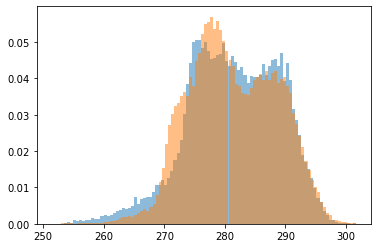

In [56]:


tasmin_cm_edit_multi = tasmin_cm_hist * np.mean(tasmin_cm_future) / np.mean(tasmin_cm_hist)
tasmin_cm_edit_add = tasmin_cm_hist + np.mean(tasmin_cm_future) - np.mean(tasmin_cm_hist)


#plt.hist(np.ndarray.flatten(tasmin_cm_edit_multi), bins =100, alpha=0.5, density=True)
plt.hist(np.ndarray.flatten(tasmin_cm_edit_add), bins =100, alpha=0.5, density=True)
plt.hist(np.ndarray.flatten(tasmin_cm_future), bins =100, alpha=0.5, density=True)
plt.show()

# 2. Evaluation part one - test assumptions

## 2. 1. Parametric methods: goodness of fit assessment + seasonality

For all parametric methods, distributions are fitted to the CDFs. Default distributions are specified in the individual debiasers. In this evaluation step, the default distributions of the specified debiasers are fitted to the data so that the user can decide whether or not to go ahead with this particular distribution or method, or whether to modify it.

In the example below, the goodness of fit of the default distribution fitted to temperature data is assessed. 
- By calculating the Akaike Information Criterion and plotting the fit and distribution for the location with the worst fit for visual inspection. If a user modifies the distribution she can compare whether this improves the fit according to the AIC
- By evaluating the quantile residuals (timeseries, their autocorrelation and a qq-plot of their transformation to normal) - in this example we see that there is a strong seasonal effect present that the normal distribution does not capture.

**To-do: write down for which methods this is relevant**

**Distribution of AIC**

**To-do: add different distribution here**

In [6]:
hurs_obs_aic = assumptions.calculate_aic('hurs', hurs_obs_validate, 
                                           scipy.stats.beta, scipy.stats.gamma)

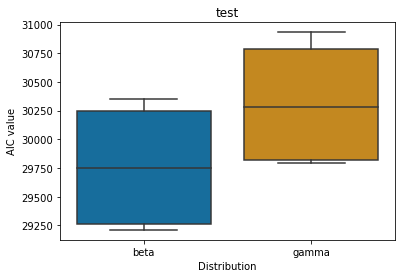

In [9]:
test = assumptions.plot_aic(variable = 'hurs', aic_values = hurs_obs_aic)
plt.show()

**Visual inspection of fit at 'worst' location**

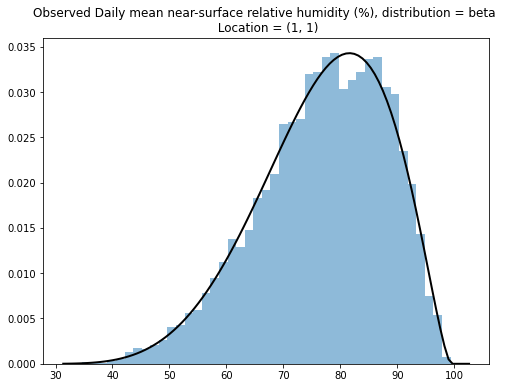

In [11]:
tas_obs_worst_fit = assumptions.calculate_and_plot_fit_worst_aic(variable = 'hurs', dataset = hurs_obs,  
                                      data_type = 'Observed', distribution = scipy.stats.beta,
                                                  aic_values = hurs_obs_aic)

**Inspection of quantile residuals**

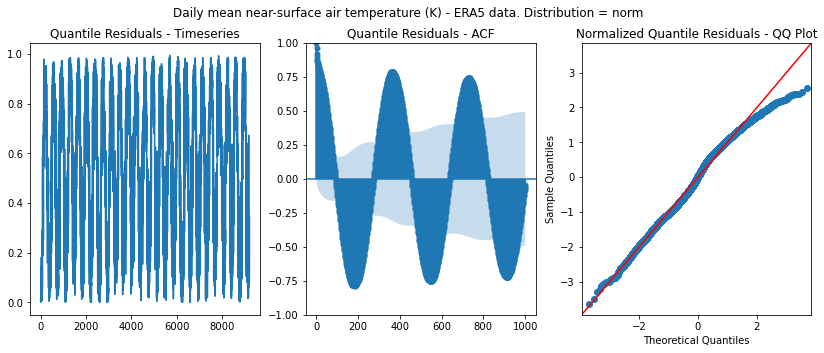

In [14]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(variable = 'tas', dataset = tas_obs[:,0,0], data_type = 'ERA5 data',
                                                      distribution = scipy.stats.norm)

## 2. 2. Stationarity / Stability of results

End-of-august add-on?

# 3. Initialise and apply de-biasers

**ISIMIP**

In [35]:
# ISIMIP
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:12<00:00,  3.13s/it]


In [36]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:09<00:00,  2.43s/it]


In [37]:
tasrange_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasrange_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_validate, **tasrange_dates_validate, verbosity='Error')
tasrange_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_future, **tasrange_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]


In [38]:
tasskew_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasskew_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_validate, **tasskew_dates_validate, verbosity='Error')
tasskew_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_future, **tasskew_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:11<00:00,  2.99s/it]


In [39]:
tasmin_val_debiased_ISIMIP, tasmax_val_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_val_debiased_ISIMIP, tasrange = tasrange_val_debiased_ISIMIP, tasskew = tasskew_val_debiased_ISIMIP)
tasmin_fut_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_fut_debiased_ISIMIP, tasrange = tasrange_fut_debiased_ISIMIP, tasskew = tasskew_fut_debiased_ISIMIP)

**CDFt**

In [7]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_val_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, **tas_dates_validate, verbosity='Error')
tas_fut_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_future, **tas_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:01<00:00,  3.62it/s]


In [12]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_val_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, **pr_dates_validate, verbosity='Error')
pr_fut_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_future, **pr_dates_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:01<00:00,  4.00it/s]


**Quantile Delta Mapping**

In [8]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate, verbosity='Error')
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future, verbosity='Error')

100%|███████████████████████████████████████████| 4/4 [00:09<00:00,  2.48s/it]


In [17]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate, verbosity='Error')
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future, verbosity='Error')

  0%|                                                   | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|███████████████████████████████████████████| 4/4 [00:24<00:00,  6.01s/it]


# 4. Evaluation of bias corrected results on validation period

After applying the bias correction methods chosen by the user, this section provides a default set of evaluation to assess both the performance of the bias corrected climate model, as well as to get an insight into potential larger biases of the underlying climate model that cannot be corrected through bias correction methods.

In order to assess the performance of a bias correction methods, we need underlying observations to compare the climate simulation to - this is not given in a future period that we actually want to apply bias correction to. We therefore split the historical period into a 'training' and a 'validation' period, and assess the performance of the BC on the validation period where results can still be compared to observations.

## 4. 1. Distribution of bias across locations

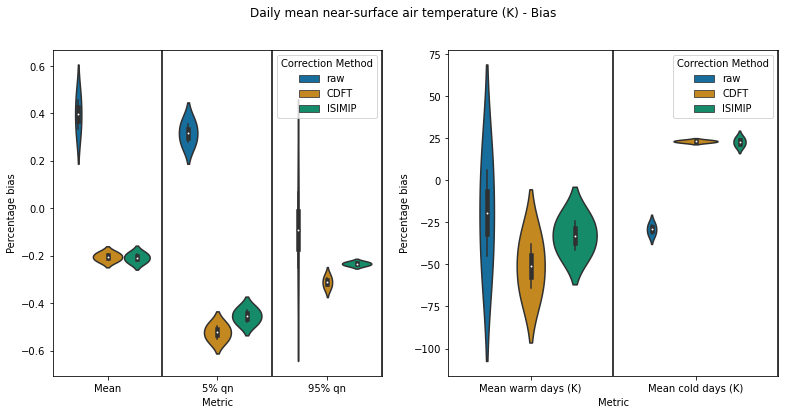

In [9]:
tas_marginal_bias_df = marginal.calculate_marginal_bias(obs_data = tas_obs_validate,
                                                          metrics = tas_metrics,
                                                          raw = tas_cm_validate,
                                                          CDFT = tas_val_debiased_CDFT,
                                                          ISIMIP = tas_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tas', bias_df = tas_marginal_bias_df)

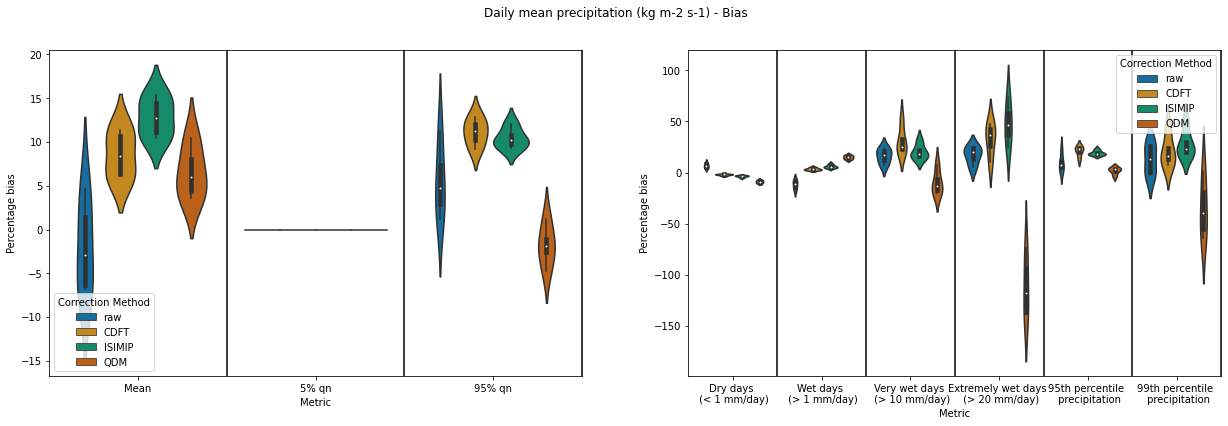

In [22]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics, obs_data = pr_obs_validate,
                                                 raw = pr_cm_validate, 
                                                 CDFT = pr_val_debiased_CDFT,
                                                 ISIMIP = pr_val_debiased_ISIMIP,
                                                 QDM = pr_val_debiased_QDM)
marginal.plot_marginal_bias(variable = 'pr', bias_array = pr_marginal_bias_data)

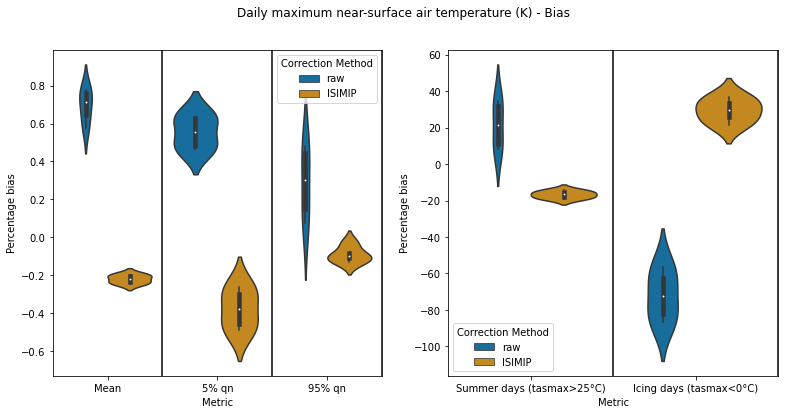

In [23]:
tasmax_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmax_metrics,
                                                 obs_data = tasmax_obs_validate,
                                                 raw = tasmax_cm_validate, 
                                                 ISIMIP = tasmax_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tasmax', bias_array = tasmax_marginal_bias_data)

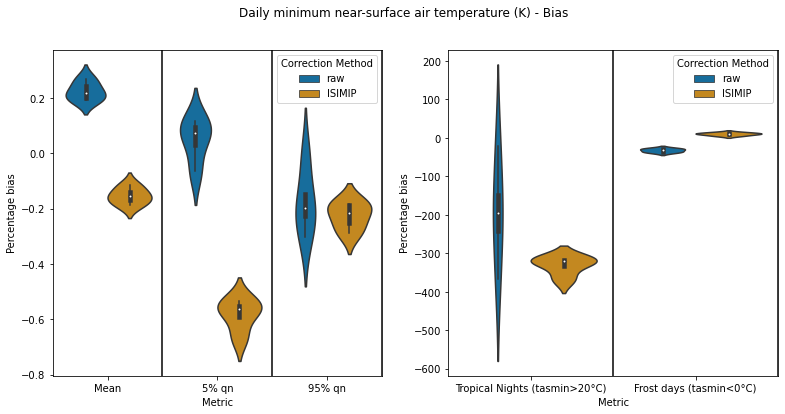

In [24]:
tasmin_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmin_metrics,
                                                 obs_data = tasmin_obs_validate,
                                                 raw = tasmin_cm_validate, 
                                                 ISIMIP = tasmin_val_debiased_ISIMIP)

marginal.plot_marginal_bias(variable = 'tasmin', bias_array = tasmin_marginal_bias_data)

## 4.2. Visualisation of spatial distribution

The shape of the distribution in the violinplot above already gives an indication of whether the bias is especially large over certain areas. The following plot explicitely shows the spacial distribution of biases. Particularly high biases in a certain region could point to deficiencies in the underlying climate model (for example, there could be a mountain range over which the climate model performs particularly badly, or other land-atmosphere interactions that are not captured).

In [11]:
print(tas_marginal_bias_df['Metric'].unique())

['Mean' '5% qn' '95% qn' 'Mean warm days (K)' 'Mean cold days (K)']


In [15]:
tas_marginal_bias_df

,Correction Method,Metric,Percentage bias
0,raw,Mean,"[[0.3356119, 0.45657456], [0.36205715, 0.41359..."
0,raw,5% qn,"[[0.3536166886963611, 0.2788513742711847], [0...."
0,raw,95% qn,"[[-0.25167990439211824, 0.06703051750434966], ..."
0,raw,Mean warm days (K),"[[-44.736842105263165, 6.122448979591836], [-5..."
0,raw,Mean cold days (K),"[[-31.68316831683168, -26.655629139072854], [-..."
0,CDFT,Mean,"[[-0.19222654, -0.21787365], [-0.18584925, -0...."
0,CDFT,5% qn,"[[-0.49805761703687573, -0.5493731254333711], ..."
0,CDFT,95% qn,"[[-0.33002366567809954, -0.29335672933074763],..."
0,CDFT,Mean warm days (K),"[[-64.03508771929823, -37.75510204081632], [-6..."
0,CDFT,Mean cold days (K),"[[22.60726072607261, 23.675496688741717], [18...."


In [12]:
def plot_histogram(variable: str, data_obs: np.ndarray, bin_number:int = 100, manual_title: str = " ", **cm_data):
    
    """
    Plots histogram of values over entire are or at single location. 
    Expects a one-dimensional array as input.

    Parameters
    ----------
    variable : str
        Variable name, has to be given in standard form specified in documentation.
    data_obs : np.ndarray
        Flattened entry of all observed values over the area, numeric entries expected
    bin_number : int
        Number of bins plotted in histogram, set to 100 by default

    """

    number_biascorrections = len(cm_data.keys())
    figure_length = number_biascorrections * 5
    plot_number = number_biascorrections

    fig, ax = plt.subplots(1, plot_number, figsize=(figure_length, 5), squeeze=True)
    
    # generate plot title
    if variable in str_to_variable_class.keys():
        plot_title = "Distribution {} ({}) over entire area".format(
                    map_variable_str_to_variable_class(variable).name, map_variable_str_to_variable_class(variable).unit
                )
    else:
        plot_title = manual_title
        raise Warning("Variable not recognized, using manual_title to generate plot_title")

    fig.suptitle(plot_title)

    i = 0
    for k, cm_data in cm_data.items():

        ax[i].hist(data_obs, bins=bin_number, alpha=0.5, label="Observed")
        ax[i].hist(cm_data, bins=bin_number, alpha=0.5, label="Climate model")
        ax[i].set_title(k)
        ax[i].legend()
        i = i + 1

    return fig

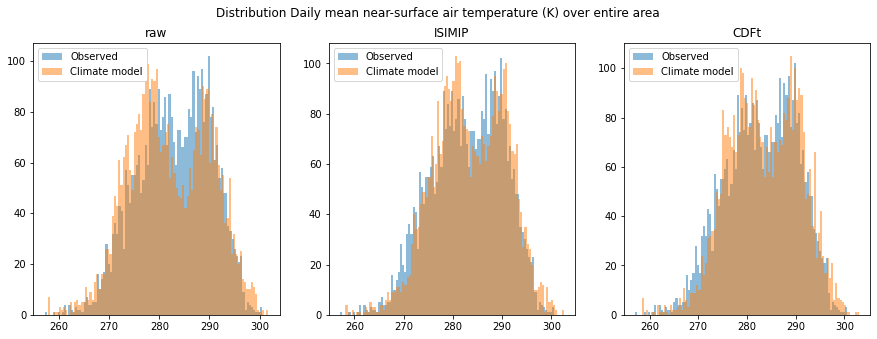

In [16]:
histogram = plot_histogram(variable='tas', data_obs=tas_obs_validate[:, 0,0], 
                           raw = tas_cm_validate[:, 0,0],  ISIMIP = tas_val_debiased_ISIMIP[:, 0,0], 
                           CDFt = tas_val_debiased_CDFT[:, 0,0])

plt.show()

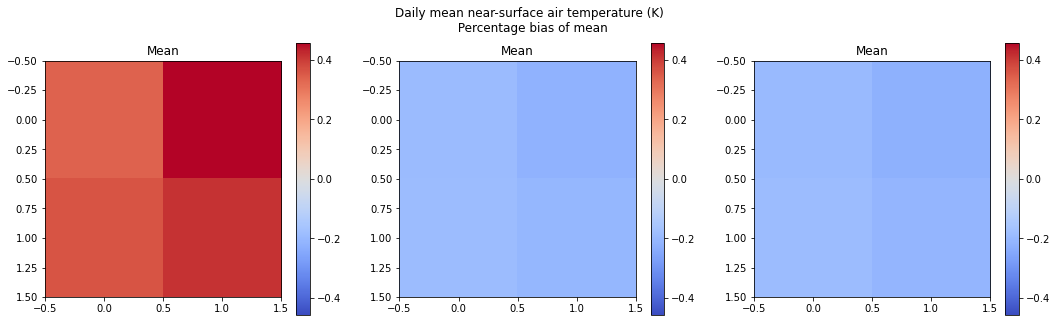

In [10]:
tas_bias_map_mean = marginal.plot_bias_spatial(variable = 'tas', metric = 'Mean', bias_df = tas_marginal_bias_df)

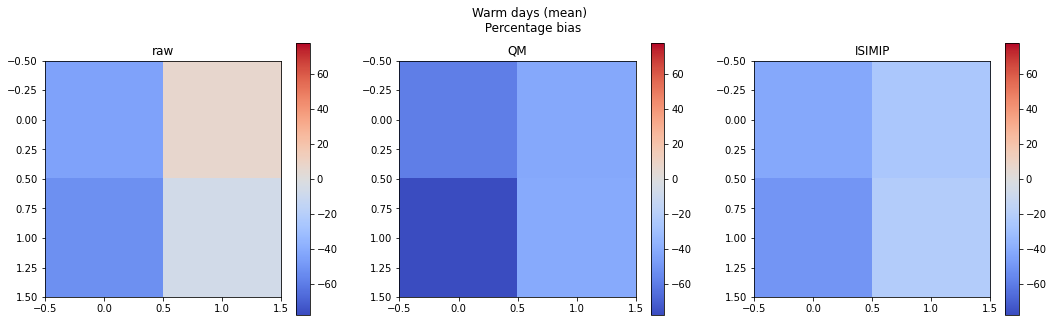

In [29]:
tas_bias_map_mean = spatial.plot_bias_spatial(variable = 'tas', statistic = 'metric', metric = warm_days, obs_data = tas_obs_validate,
                                              raw = tas_cm_validate, QM = tas_val_debiased_QM, 
                                              ISIMIP = tas_val_debiased_ISIMIP)

## 4.3. Threshold metrics: spatiotemporal extent and value above threshold

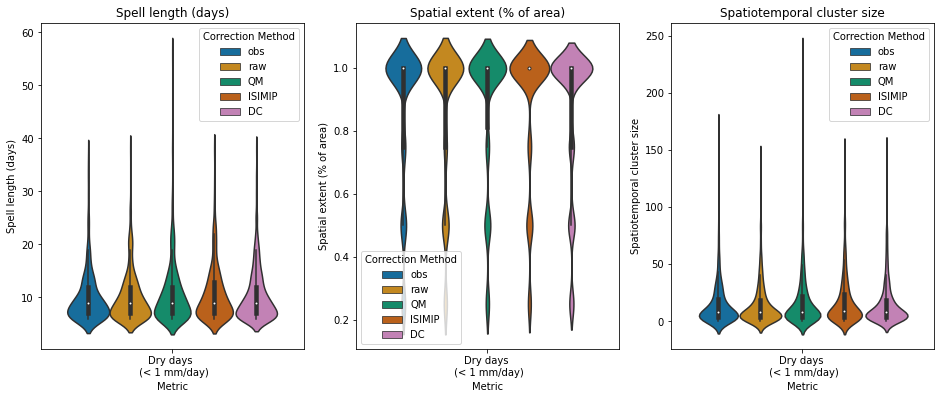

In [30]:
dry_days.plot_clusters_violinplots(minimum_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

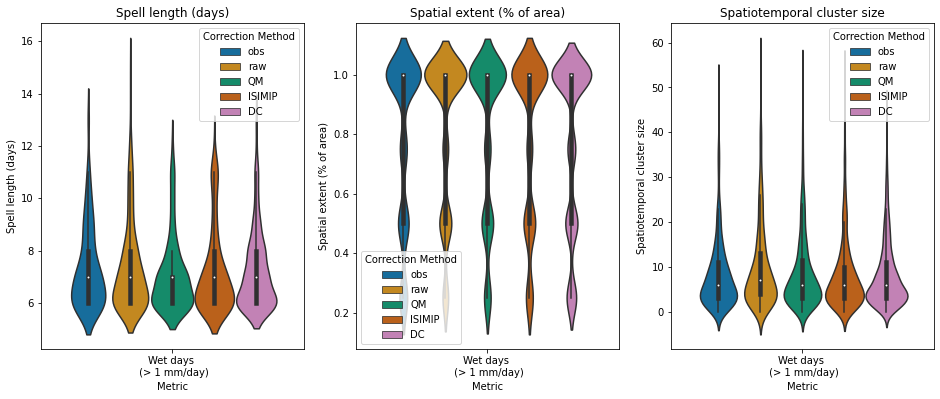

In [31]:
wet_days.plot_clusters_violinplots(minimum_length = 5, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

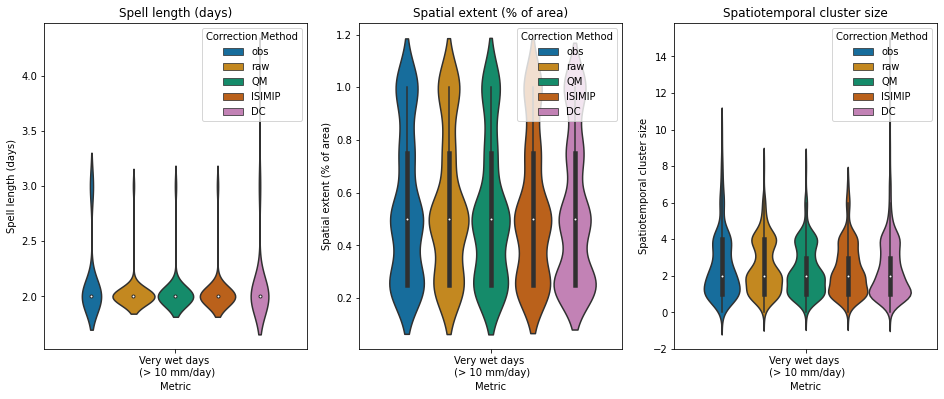

In [32]:
R10mm.plot_clusters_violinplots(minimum_length = 1, obs = pr_obs_validate,
                                                   raw = pr_cm_validate, QM = pr_val_debiased_QM, 
                                                   ISIMIP = pr_val_debiased_ISIMIP, DC = pr_val_debiased_DC)

## 4.4. Correlation

### Spatial correlation - distribution of RMSE between two correlation matrices

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_75372/812009769.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


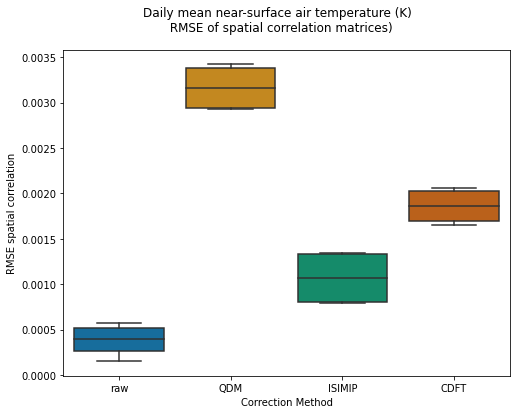

In [25]:
tas_rmsd_spatial = correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                         obs_data = tas_obs_validate, raw = tas_cm_future,
                                                         QDM = tas_val_debiased_QDM, ISIMIP = tas_val_debiased_ISIMIP,
                                                         CDFT = tas_val_debiased_CDFT)
tas_rmsd_spatial_plot = correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

### Multivariate structure - difference in correlation matrices

**Spatial plot of locationwise correlation (Pearson) between temperature and precipitation**

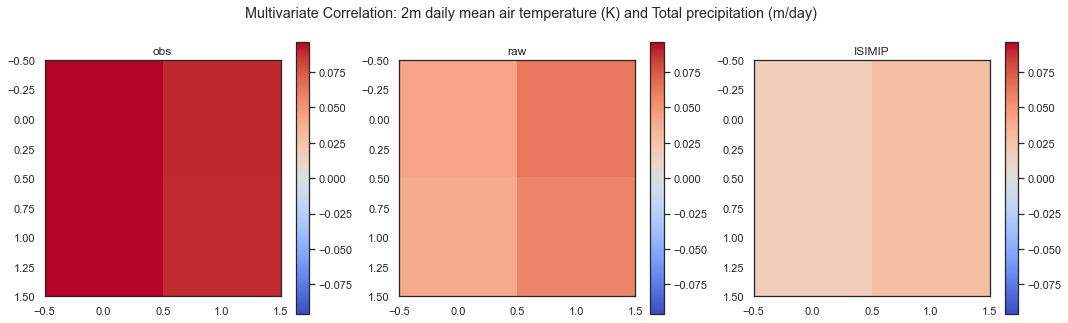

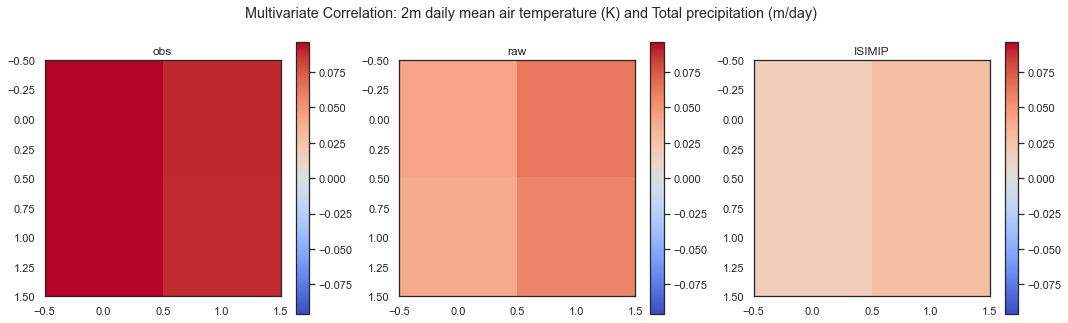

In [215]:
correlation.calculate_multivariate_correlation_locationwise(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

**Investigation into one locations shows that relationship is not really linear**

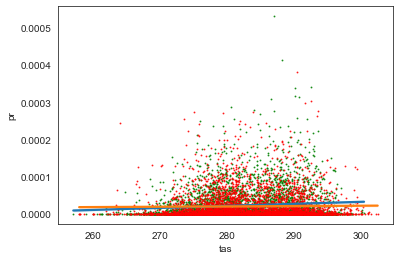

In [61]:
tas_pr_obs, tas_pr_ISIMIP = correlation.define_multivariate_dataframes(variables = ['tas', 'pr'],
                               datasets_obs = [tas_obs_validate, pr_obs_validate],
                               datasets_bc = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])

tas_pr_obs

plot_correlation_tas_pr_ISIMIP = correlation.plot_direct_comparison_of_correlation_at_gridpoint(variables = ['tas', 'pr'], 
                                                                                       obs_dataframe = tas_pr_obs,
                                                                                       bc_dataframe  =tas_pr_ISIMIP)


**Bootstrapping applied to correlation estimate, then KS test to see whether correlation coefficient of observed and bias corrected data can have been drawn from the same distribution**

KstestResult(statistic=0.998, pvalue=7.399507995628047e-297)

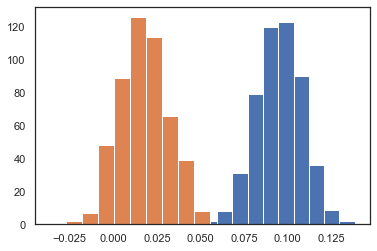

In [219]:
from scipy.stats import kstest

corr_estimates_obs = correlation.calculate_corr_bs_replicates(tas_pr_obs, 500)
corr_estimates_isimip = correlation.calculate_corr_bs_replicates(tas_pr_ISIMIP, 500)

plt.hist(corr_estimates_obs)
plt.hist(corr_estimates_isimip)

kstest(corr_estimates_obs, corr_estimates_isimip, 'auto')

**Exploration of mutual information instead of correlation - currently very dependent on bin size of constructed histogram**

In [103]:
mi_estimates_obs = draw_bs_replicates_mi(tas_pr_obs, 5, 500)
mi_estimates_isimip = draw_bs_replicates_mi(tas_pr_ISIMIP, 5, 500)

plt.hist(mi_estimates_obs)
plt.hist(mi_estimates_isimip, alpha=0.8)

NameError: name 'draw_bs_replicates_mi' is not defined

# 5. Trend preservation

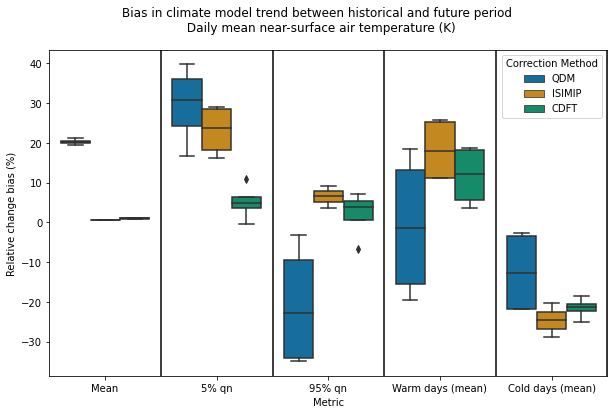

In [31]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', metric_collection = tas_metrics, 
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future, 
                                                  QDM = [tas_val_debiased_QDM, tas_fut_debiased_QDM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  CDFT = [tas_val_debiased_CDFT, tas_fut_debiased_CDFT])

trend.plot_future_trend_bias(variable ='tas', bias_array = tas_trend_bias_data)

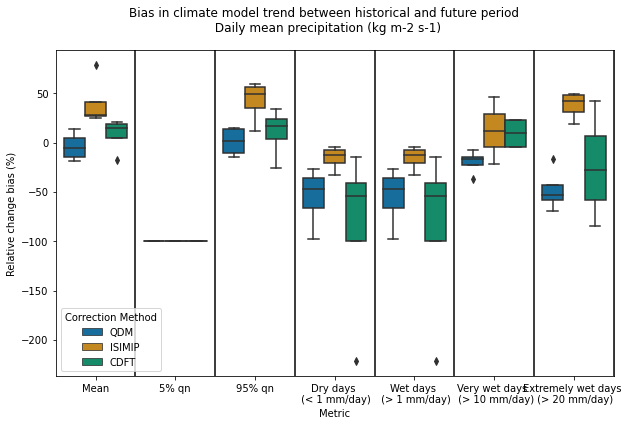

In [32]:
pr_trend_bias_data = trend.calculate_future_trend_bias(variable = 'pr', metric_collection = pr_metrics, 
                                                  raw_validate = pr_cm_validate, raw_future = pr_cm_future, 
                                                  QDM = [pr_val_debiased_QDM, pr_fut_debiased_QDM],
                                                  ISIMIP = [pr_val_debiased_ISIMIP, pr_fut_debiased_ISIMIP],
                                                  CDFT = [pr_val_debiased_CDFT, pr_fut_debiased_CDFT])

trend.plot_future_trend_bias(variable ='pr', bias_array = pr_trend_bias_data)

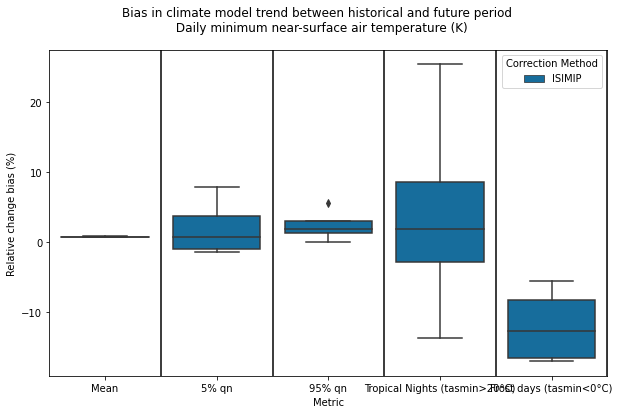

In [35]:
tasmin_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tasmin', metric_collection = tasmin_metrics, 
                                                  raw_validate = tasmin_cm_validate, raw_future = tasmin_cm_future, 
                                                  ISIMIP = [tasmin_val_debiased_ISIMIP, tasmin_fut_debiased_ISIMIP])

trend.plot_future_trend_bias(variable ='tasmin', bias_array = tasmin_trend_bias_data)

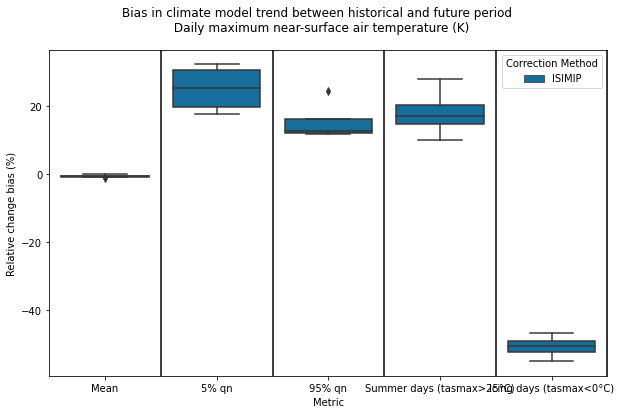

In [36]:
tasmax_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tasmax', metric_collection = tasmax_metrics, 
                                                  raw_validate = tasmax_cm_validate, raw_future = tasmax_cm_future, 
                                                  ISIMIP = [tasmax_val_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP])

trend.plot_future_trend_bias(variable ='tasmax', bias_array = tasmax_trend_bias_data)

In [112]:
tas_pr_obs, tas_pr_isimip = _create_multivariate_dataframes(variables = ['tas', 'pr'], datasets_obs = [tas_obs_validate, pr_obs_validate], datasets_bc = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP], gridpoint = (1,1))

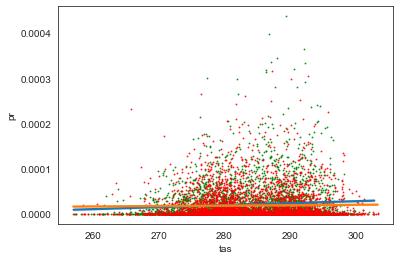

In [113]:
plot_correlation_single_location(variables = ['tas', 'pr'], obs_df = tas_pr_obs, bc_df = tas_pr_isimip)

In [100]:
def _calculate_chi(metric1, metric2, dataset1, dataset2):
    
    metric1_instances = metric1.calculate_instances_of_threshold_exceedance(dataset1)
    metric2_instances = metric2.calculate_instances_of_threshold_exceedance(dataset2)
    
    metric1_instances[metric1_instances==0]=2
    
    cooccurrence = (metric1_instances == metric2_instances).astype(int)
    
    if np.any(np.einsum("ijk -> jk", metric2_instances)) is 0:
        raise ValueError("There is at least one location where threshold exceedance for metric2 does not occur. Calculation cannot be performed")
    
    chi = np.einsum("ijk -> jk", cooccurrence) / np.einsum("ijk -> jk", metric2_instances)
    
    print(chi)
    return chi
    
    
    
def calculate_conditional_joint_threshold_exceedance(metric1, metric2, **climate_data):
    
    conditional_exceedance_dfs = []
    
    compound_metric_name = "{} given {}".format(metric1.name, metric2.name)
    
    for climate_data_key, climate_data_value in climate_data.items():
        
        chi = _calculate_chi(metric1, metric2, climate_data_value[0], climate_data_value[1])*100
        
        conditional_exceedance_dfs.append(
            pd.DataFrame(
                data={
                    "Correction Method": climate_data_key,
                    "Compound metric": compound_metric_name,
                    "Conditional exceedance probability": [chi],
                }
            )
        )
        
    conditional_exceedance = pd.concat(conditional_exceedance_dfs)
    
    return conditional_exceedance
        
def plot_conditional_joint_threshold_exceedance(conditional_exceedance_df: pd.DataFrame):
    
    # unpack dataframe
    conditional_exceedance_df_unpacked = _unpack_df_of_numpy_arrays(df=conditional_exceedance_df, numpy_column_name = "Conditional exceedance probability")

    # create figure and plot
    fig = plt.figure(figsize=(10, 6))
    ax = seaborn.boxplot(
        y="Conditional exceedance probability", x="Correction Method", data=conditional_exceedance_df_unpacked, 
        palette="colorblind"
    )
    [ax.axvline(x + 0.5, color="k") for x in ax.get_xticks()]
    
    # generate and set plot title
    plot_title = "Probability of {}".format(conditional_exceedance_df_unpacked.iat[0, 1])
    fig.suptitle(plot_title)
    
    return fig

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_76770/4094148105.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if np.any(np.einsum("ijk -> jk", metric2_instances)) is 0:


In [101]:
dry_frost_data = calculate_conditional_exceedance(metric1 = dry_days, metric2 = frost_days,
                                                  obs = [pr_obs_validate, tasmin_obs_validate],
                                                  raw = [pr_cm_validate, tasmin_cm_validate],
                                                 ISIMIP = [pr_val_debiased_ISIMIP, tasmin_val_debiased_ISIMIP])

[[0.7384844  0.75034294]
 [0.72589532 0.73825503]]
[[0.6619256  0.65950591]
 [0.68       0.67052632]]
[[0.74914676 0.73968254]
 [0.74626866 0.74404762]]


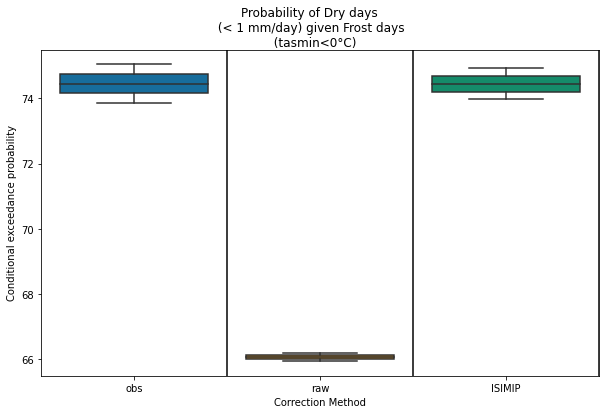

In [102]:
plot_dry_frost = plot_conditional_exceedance(dry_frost_data)
plt.show()